In [ ]:
'''Blog: https://blog.insightdatascience.com/explicit-matrix-factorization-als-sgd-and-all-that-jazz-b00e4d9b21ea

In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [2]:
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip
!cd ml-100k/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  16.0M      0 --:--:-- --:--:-- --:--:-- 15.9M
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

In [4]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


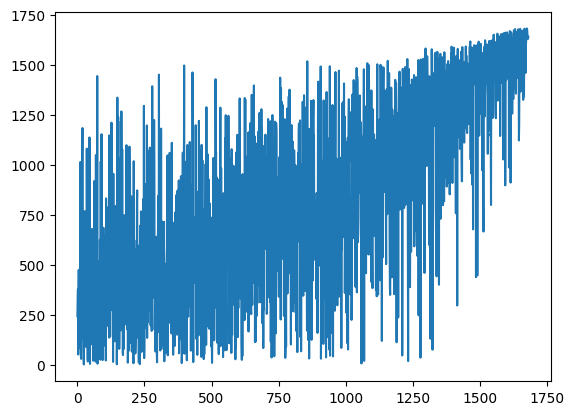

In [65]:
checking = df.item_id.unique()

import matplotlib.pyplot as plt

plt.plot(checking)

In [5]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [20]:
print(str(n_users) + ' users')
print(str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

943 users
1682 items
Sparsity: 6.30%


In [23]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0],
                                        size=10,
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test

In [24]:
train, test = train_test_split(ratings)

In [26]:
from numpy.linalg import solve
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)


class ExplicitMF():
    def __init__(self,
                 ratings,
                 n_factors=40,
                 item_reg=0.0,
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty
        entries in a matrix. The terminology assumes a
        ratings matrix which is ~ user x item

        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings

        n_factors : (int)
            Number of latent factors to use in matrix
            factorization model

        item_reg : (float)
            Regularization term for item latent factors

        user_reg : (float)
            Regularization term for user latent factors

        verbose : (bool)
            Whether or not to printout training progress
        """

        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI),
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda

            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI),
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))

        self.partial_train(n_iter)

    def partial_train(self, n_iter):
        """
        Train model for n_iter iterations. Can be
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print('\tcurrent iteration: {}'.format(ctr))
            self.user_vecs = self.als_step(self.user_vecs,
                                           self.item_vecs,
                                           self.ratings,
                                           self.user_reg,
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs,
                                           self.user_vecs,
                                           self.ratings,
                                           self.item_reg,
                                           type='item')
            ctr += 1

    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)

        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)

    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.

        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).

        The function creates two new class attributes:

        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print('Train mse: ' + str(self.train_mse[-1]))
                print('Test mse: ' + str(self.test_mse[-1]))
            iter_diff = n_iter

In [27]:
MF_ALS = ExplicitMF(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

In [28]:
predictions = MF_ALS.predict_all()

In [30]:
predictions.shape

(943, 1682)

In [70]:
movie_df = pd.read_csv('movies_metadata.csv', usecols=['id', 'title', 'genres'])

In [74]:
def user_rated_movie_indexes(user_id):
  user_ratings = list(ratings[user_id][:])
  movie_indexes = []
  for i in range(len(user_ratings)):
    if user_ratings[i] != 0 and user_ratings[i] > 3:
      movie_indexes.append(i+1)

  user_liked = []
  for idx in movie_indexes:
      pass
  return movie_indexes

check = user_rated_movie_indexes(1)

print(check)

print(ratings[1][:50])

[1, 13, 14, 25, 50, 100, 111, 127, 237, 242, 251, 255, 257, 269, 272, 273, 275, 276, 277, 279, 282, 283, 284, 285, 286, 292, 293, 295, 297, 299, 300, 301, 302, 303, 304, 306, 310, 311, 313, 316]
[4. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 4. 4. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0.
 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 5.]
